In [1]:
import glob
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ase.io import read as read_xyz
from dscribe.descriptors import SOAP
from astartes import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor

from tqdm import tqdm
from paretoset import paretoset
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [2]:
RANDOM_SEED = 21

SOAP_JOBS = 6
TRAIN_SIZE = 0.80
TREE_MAX_DEPTH = 10
PCA_MAX_COMPONENTS = 15
PCA_MIN_CUMULATIVE_VAR = 0.95

## Data Loading

In [12]:
file_names = [Path(x).name for x in sorted(glob.glob("../data/raw/*.xyz"))]
structures = [read_xyz(f"../data/raw/{x}") for x in file_names]
energy_levels = np.array([float(list(x.info.keys())[0]) for x in structures])

print(f"Loaded: {len(file_names)} structures.")

Loaded: 999 structures.


## Cross Validation

In [13]:
def get_model(model_name: str, pca_components: int):
    if model_name == "extra-trees":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", ExtraTreesRegressor(max_depth=TREE_MAX_DEPTH, random_state=RANDOM_SEED))
        ])
    elif model_name == "xgboost":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", XGBRegressor(max_depth=TREE_MAX_DEPTH, random_state=RANDOM_SEED))
        ])
    elif model_name == "lightgbm":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", LGBMRegressor(verbose=-1, max_depth=TREE_MAX_DEPTH, random_state=RANDOM_SEED))
        ])
    elif model_name == "stacking":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", StackingRegressor(
                estimators=[
                    ("etr", ExtraTreesRegressor(max_depth=TREE_MAX_DEPTH, random_state=RANDOM_SEED)), 
                    ("xgb", XGBRegressor(max_depth=TREE_MAX_DEPTH, random_state=RANDOM_SEED)), 
                    ("lgb", LGBMRegressor(verbose=-1, max_depth=TREE_MAX_DEPTH, random_state=RANDOM_SEED))
                ]
            ))
        ])
    
    raise ValueError("Unknown model name!")

In [14]:
param_space = list(ParameterGrid({
    "n_max": range(1, 11),
    "l_max": range(1, 11)
}))

len(param_space)

100

In [16]:
results = []

with warnings.catch_warnings(action="ignore"):
    for param in (pbar := tqdm(param_space)):
        soap = SOAP(
            r_cut=5,
            n_max=param["n_max"],
            l_max=param["l_max"],
            species=["Au"],
            average="outer",
            periodic=False,
            sparse=False,
        )

        X = soap.create(structures, n_jobs=SOAP_JOBS)
        y = energy_levels.copy()

        # ignore test set
        X_train, _, y_train, _ = train_test_split(X, y, sampler="random", train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

        pca = PCA(n_components=min(X.shape[1], PCA_MAX_COMPONENTS)).fit(StandardScaler().fit_transform(X))
        num_pc = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= PCA_MIN_CUMULATIVE_VAR) + 1

        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
        for i, (train_index, val_index) in enumerate(cv.split(X, y)):
            X_train, y_train = X[train_index], y[train_index]
            X_val, y_val = X[val_index], y[val_index]

            for model_name in ["extra-trees", "xgboost", "lightgbm", "stacking"]:
                pbar.set_description_str(f"Fold: {i+1} - Model: {model_name}")

                model = get_model(model_name, num_pc)
                model.fit(X_train, y_train)

                y_preds = model.predict(X_val)
                results.append({
                    "fold": i,
                    "model_name": model_name,
                    **param,
                    "num_desc": X.shape[1],
                    "pc": num_pc,
                    "r2": r2_score(y_val, y_preds),
                    "mae": mean_absolute_error(y_val, y_preds),
                    "rmse": root_mean_squared_error(y_val, y_preds),
                })

Fold: 5 - Model: stacking: 100%|██████████| 100/100 [13:53<00:00,  8.33s/it]  


## Candidate Parameters using Skyline Query

In [18]:
df_results = pd.DataFrame(results)
df_results.to_csv("../data/soap-grid_search.csv", index=None)

df_results.head()

,fold,model_name,l_max,n_max,num_desc,pc,r2,mae,rmse
0,0,extra-trees,1,1,2,1,0.656864,1.233067,1.711660
1,0,xgboost,1,1,2,1,0.633332,1.265364,1.769379
2,0,lightgbm,1,1,2,1,0.653251,1.262744,1.720649
3,0,stacking,1,1,2,1,0.655513,1.234095,1.715028
4,1,extra-trees,1,1,2,1,0.495646,1.329656,1.715489


In [8]:
df_results = pd.read_csv("../data/soap-grid_search.csv")
df_results.head()

,fold,model_name,l_max,n_max,num_desc,pc,r2,mae,rmse
0,0,extra-trees,1,1,2,1,0.656864,1.233067,1.711660
1,0,xgboost,1,1,2,1,0.633332,1.265364,1.769379
2,0,lightgbm,1,1,2,1,0.653251,1.262744,1.720649
3,0,stacking,1,1,2,1,0.655513,1.234095,1.715028
4,1,extra-trees,1,1,2,1,0.495646,1.329656,1.715489


In [9]:
df_summary = df_results[["model_name", "n_max", "l_max", "mae", "rmse", "r2"]] \
    .groupby(["model_name", "n_max", "l_max"]) \
    .mean() \
    .reset_index() \
    .sort_values("r2", ascending=False)

df_summary.head()

,model_name,n_max,l_max,mae,rmse,r2
208,stacking,1,9,0.454840,0.676203,0.942758
6,extra-trees,1,7,0.467366,0.692226,0.939970
206,stacking,1,7,0.465432,0.691668,0.939895
8,extra-trees,1,9,0.476744,0.702218,0.938685
108,lightgbm,1,9,0.448946,0.705672,0.936539


In [16]:
pareto_mask = paretoset(df_summary.drop(columns=["model_name"]), sense=["min", "min", "min", "min", "max"])

dd = df_summary[pareto_mask] \
    .sort_values("r2", ascending=False) \
    .merge(df_results[["n_max", "l_max", "num_desc"]].drop_duplicates(), on=["n_max", "l_max"]) \
    .round(4)

dd.to_csv("../data/soap-skyline.csv", index=None)

dd.head()

,model_name,n_max,l_max,mae,rmse,r2,num_desc
0,stacking,1,9,0.4548,0.6762,0.9428,10
1,extra-trees,1,7,0.4674,0.6922,0.9400,8
2,stacking,1,7,0.4654,0.6917,0.9399,8
3,lightgbm,1,9,0.4489,0.7057,0.9365,10
4,xgboost,1,7,0.4609,0.7827,0.9219,8


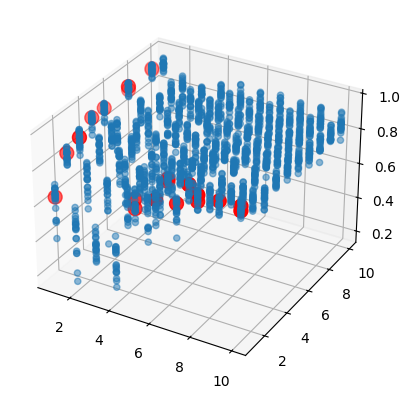

In [64]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ax.scatter(df_results["n_max"], df_results["l_max"], df_results["r2"], alpha=0.5)
ax.scatter(dd["n_max"], dd["l_max"], dd["r2"], c="red", s=100)

# ax.view_init(elev=35, azim=-120, roll=0)

plt.show()

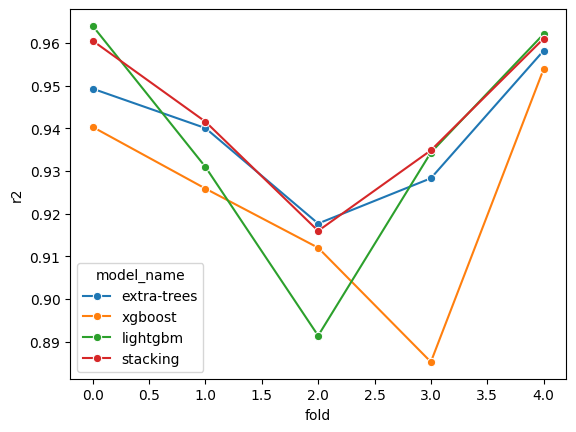

In [17]:
dd = df_results[(df_results["n_max"] == 1) & (df_results["l_max"] == 9)]

sns.lineplot(dd, x="fold", y="r2", hue="model_name", marker="o")

plt.show()

## Export Features

In [23]:
soap = SOAP(
    r_cut=5,
    n_max=1,
    l_max=9,
    species=["Au"],
    average="outer",
    periodic=False,
    sparse=False,
)

X = soap.create(structures, n_jobs=SOAP_JOBS)
X.shape

(999, 10)

In [28]:
df_final = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df_final["file_name"] = file_names
df_final["energy"] = energy_levels

df_final.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,file_name,energy
0,8.312640,0.013240,0.002026,0.000578,0.000059,0.000005,3.614525e-07,2.891632e-08,3.363042e-09,9.584413e-11,0.xyz,-1547.657785
1,8.903285,0.026071,0.002458,0.000283,0.000031,0.000006,1.041832e-06,4.556548e-08,2.465568e-09,8.548989e-11,1.xyz,-1552.612539
2,9.287031,0.033807,0.002167,0.000183,0.000028,0.000006,1.474569e-06,6.771517e-08,1.839670e-09,8.525103e-11,10.xyz,-1555.417784
3,8.923366,0.023786,0.001960,0.000339,0.000035,0.000007,9.650267e-07,5.893078e-08,2.394213e-09,1.202439e-10,100.xyz,-1552.217633
4,9.086140,0.026782,0.001243,0.000245,0.000049,0.000005,1.253184e-06,4.471700e-08,3.935182e-09,1.254421e-10,101.xyz,-1552.886542


In [31]:
df_final.to_csv("../data/gold-features.csv", index=None)